In [ ]:
!pip install tensorflow
import numpy as np
import pandas as pd


%matplotlib inline 

import cv2
import matplotlib.pyplot as plt
import os


In [ ]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 4

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [ ]:
!pip install keras

In [ ]:
resnet_weights_path = 'resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
print(resnet_weights_path)

In [ ]:
ls

In [ ]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming 10 classes
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

In [ ]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate=0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=r"./train/",
    target_size=(image_size, image_size),
    color_mode="rgb",
    
    class_mode="categorical",
    shuffle=True,
    
    batch_size=BATCH_SIZE_VALIDATION
)

In [ ]:
valid_generator = train_datagen.flow_from_directory(
    directory=r"./valid/",
    target_size=(image_size, image_size),
    color_mode="rgb",
    
    class_mode="categorical",
    shuffle=True,
    
    batch_size=BATCH_SIZE_VALIDATION
)

In [ ]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(valid_generator))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.keras', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
!pip install sklearn

In [ ]:
!mkdir working

In [ ]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=valid_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.save_weights("../best.hdf5")


In [ ]:


print(fit_history.history.keys())



In [ ]:
 
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()



In [ ]:
ls

In [ ]:

test_generator = train_datagen.flow_from_directory(
    directory=r"./test/",
    target_size=(image_size, image_size),
    color_mode="rgb",
    batch_size=BATCH_SIZE_TESTING,
    class_mode=None,
    shuffle=False,
    seed=123
)

# ??train_datagen.flow_from_directory

In [ ]:
ls

In [ ]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)


In [ ]:
TEST_DIR = 'test/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Set paths to your dataset folders
train_dir = '/home/esidserver/datasets/testing_cls/train/'
val_dir = '/home/esidserver/datasets/testing_cls/val/'
test_dir = '/home/esidserver/datasets/testing_cls/test/'

# Image data generator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load the ResNet-50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=250,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=250,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

# Save the final model
model.save('resnet50_final_model.keras')


Found 5193 images belonging to 4 classes.
Found 1484 images belonging to 4 classes.
Found 740 images belonging to 4 classes.
Epoch 1/250


/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724847912.803130  335646 service.cc:146] XLA service 0x7b086c0026c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724847912.803209  335646 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-28 19:25:13.133559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 19:25:14.421861: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2

  1/163 ━━━━━━━━━━━━━━━━━━━━ 47:45 18s/step - accuracy: 0.2188 - loss: 1.5142

I0000 00:00:1724847920.203499  335646 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/163 ━━━━━━━━━━━━━━━━━━━━ 24s 436ms/step - accuracy: 0.2699 - loss: 1.4009

2024-08-28 19:26:09.442768: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5694', 12 bytes spill stores, 12 bytes spill loads



162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.2738 - loss: 1.3932

2024-08-28 19:26:47.394587: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1719', 12 bytes spill stores, 12 bytes spill loads



163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 565ms/step - accuracy: 0.2740 - loss: 1.3930 - val_accuracy: 0.3706 - val_loss: 1.3356
Epoch 2/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 381ms/step - accuracy: 0.3807 - loss: 1.3278 - val_accuracy: 0.4420 - val_loss: 1.2673
Epoch 3/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 384ms/step - accuracy: 0.3927 - loss: 1.2872 - val_accuracy: 0.3026 - val_loss: 1.2880
Epoch 4/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 402ms/step - accuracy: 0.4139 - loss: 1.2618 - val_accuracy: 0.4515 - val_loss: 1.2254
Epoch 5/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 391ms/step - accuracy: 0.4354 - loss: 1.2407 - val_accuracy: 0.4832 - val_loss: 1.1951
Epoch 6/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 390ms/step - accuracy: 0.4413 - loss: 1.2164 - val_accuracy: 0.5398 - val_loss: 1.1573
Epoch 7/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 401ms/step - accuracy: 0.4587 - loss: 1.1948 - val_accuracy: 0.4939 - val_loss: 1.1352
Epoch 8/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 398ms/step - accuracy: 0.4511 - loss: 1.18

2024-08-28 23:47:29.324606: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15690', 76 bytes spill stores, 76 bytes spill loads



163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 625ms/step - accuracy: 0.4062 - loss: 38.0377 - val_accuracy: 0.2487 - val_loss: 35.3444
Epoch 2/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 355ms/step - accuracy: 0.7646 - loss: 1.4022 - val_accuracy: 0.2487 - val_loss: 26.5567
Epoch 3/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 347ms/step - accuracy: 0.8274 - loss: 0.7819 - val_accuracy: 0.2487 - val_loss: 35.6060
Epoch 4/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 355ms/step - accuracy: 0.8545 - loss: 0.5429 - val_accuracy: 0.2513 - val_loss: 31.0879
Epoch 5/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 349ms/step - accuracy: 0.8785 - loss: 0.3898 - val_accuracy: 0.4144 - val_loss: 8.9663
Epoch 6/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 357ms/step - accuracy: 0.8996 - loss: 0.3316 - val_accuracy: 0.7102 - val_loss: 1.7920
Epoch 7/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 372ms/step - accuracy: 0.9158 - loss: 0.2448 - val_accuracy: 0.8673 - val_loss: 0.4938
Epoch 8/250
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 368ms/step - accuracy: 0.9308 - loss:

2024-08-29 02:03:11.477455: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1719', 4 bytes spill stores, 4 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.9996 - loss: 0.0011    
Test Accuracy: 0.9986486434936523, Test Loss: 0.0035873239394277334


: 

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np
import pandas as pd
from tqdm import tqdm

# Set paths to your dataset folders
train_dir = '/home/esidserver/datasets/testing_cls/train/'
val_dir = '/home/esidserver/datasets/testing_cls/val/'
test_dir = '/home/esidserver/datasets/testing_cls/test/'

# Image data generator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)

# Load the ResNet-50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define a custom callback to display live metrics
class LiveMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Calculate precision, recall, f1-score using validation data
        val_preds = self.model.predict(val_generator)
        val_pred_classes = np.argmax(val_preds, axis=1)
        val_true_classes = val_generator.classes

        precision, recall, f1, _ = precision_recall_fscore_support(val_true_classes, val_pred_classes, average='weighted')

        # Using F1-score as an approximation for mAP@50 and mAP@50-95
        map50 = f1
        map50_95 = f1

        # Print live metrics table
        results = {
            "Epoch": epoch + 1,
            "Validation Accuracy": f"{logs['val_accuracy']:.4f}",
            "Precision": f"{precision:.4f}",
            "Recall": f"{recall:.4f}",
            "mAP@50": f"{map50:.4f}",
            "mAP@50-95": f"{map50_95:.4f}"
        }
        results_df = pd.DataFrame([results])
        print(results_df)

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_best_model.keras', save_best_only=True, monitor='val_loss')
live_metrics = LiveMetrics()

# Train the model with live metrics callback
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, live_metrics]
)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning and live metrics callback
history_finetune = model.fit(
    train_generator,
    epochs=2,  # Fine-tuning for 100 epochs
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, live_metrics]
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Save the final model
model.save('resnet50_final_model.keras')

# Generate predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_labels = list(test_generator.class_indices.keys())

# Display the confusion matrix
print(f"Confusion Matrix:\n{cm}")


Found 5193 images belonging to 4 classes.
Found 1484 images belonging to 4 classes.
Found 740 images belonging to 4 classes.
Epoch 1/5
 43/163 ━━━━━━━━━━━━━━━━━━━━ 44s 375ms/step - accuracy: 0.2408 - loss: 1.4217

2024-09-02 14:20:15.573553: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5694', 12 bytes spill stores, 12 bytes spill loads



162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.2704 - loss: 1.3937

2024-09-02 14:21:16.763369: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1719', 12 bytes spill stores, 12 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step
   Epoch Validation Accuracy Precision  Recall  mAP@50 mAP@50-95
0      1              0.4420    0.4645  0.2729  0.1917    0.1917
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 610ms/step - accuracy: 0.2709 - loss: 1.3934 - val_accuracy: 0.4420 - val_loss: 1.3176
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step
   Epoch Validation Accuracy Precision  Recall  mAP@50 mAP@50-95
0      2              0.3666    0.2835  0.2588  0.1904    0.1904
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 448ms/step - accuracy: 0.3656 - loss: 1.3320 - val_accuracy: 0.3666 - val_loss: 1.2784
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step
   Epoch Validation Accuracy Precision  Recall  mAP@50 mAP@50-95
0      3              0.4508    0.2077  0.2332  0.1764    0.1764
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 445ms/step - accuracy: 0.4047 - loss: 1.2856 - val_accuracy: 0.4508 - val_loss: 1.2463
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
   Epoch Validation Accuracy Precision  Recall  mAP@50 m

/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/2


2024-09-02 14:27:10.465755: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15690', 76 bytes spill stores, 76 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step
   Epoch Validation Accuracy Precision  Recall  mAP@50 mAP@50-95
0      1              0.2635    0.2224  0.2507  0.1136    0.1136
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 753ms/step - accuracy: 0.4565 - loss: 2.5147 - val_accuracy: 0.2635 - val_loss: 1.7609
Epoch 2/2


/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step
   Epoch Validation Accuracy Precision  Recall  mAP@50 mAP@50-95
0      2              0.2493    0.0617  0.2473  0.0987    0.0987
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 430ms/step - accuracy: 0.8470 - loss: 0.3905 - val_accuracy: 0.2493 - val_loss: 2.6635


/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 1/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.0625 - loss: 1.2513

/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1371 - loss: 1.6864

2024-09-02 14:31:00.248505: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1719', 4 bytes spill stores, 4 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.1464 - loss: 1.6936
Test Accuracy: 0.2541, Test Loss: 1.7766
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step
Confusion Matrix:
[[  4   0 183   1]
 [  5   0 179   0]
 [  0   0 184   0]
 [  9   0 175   0]]


Found 5193 images belonging to 4 classes.
Found 1484 images belonging to 4 classes.
Found 740 images belonging to 4 classes.
Epoch 1/5


/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 472ms/step - accuracy: 0.2730 - loss: 1.4188 - val_accuracy: 0.2817 - val_loss: 1.3258
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 402ms/step - accuracy: 0.3474 - loss: 1.3393 - val_accuracy: 0.3349 - val_loss: 1.3055
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 420ms/step - accuracy: 0.4005 - loss: 1.3018 - val_accuracy: 0.4178 - val_loss: 1.2517
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 410ms/step - accuracy: 0.4301 - loss: 1.2635 - val_accuracy: 0.4427 - val_loss: 1.2288
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 413ms/step - accuracy: 0.4188 - loss: 1.2414 - val_accuracy: 0.4764 - val_loss: 1.1763
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 651ms/step - accuracy: 0.4642 - loss: 2.5812 - val_accuracy: 0.2554 - val_loss: 2.7156
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 410ms/step - accuracy: 0.8412 - loss: 0.4134 - val_accuracy: 0.2729 - val_loss: 1.9116
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.2562 - loss: 2.7035
Final Validation Accurac

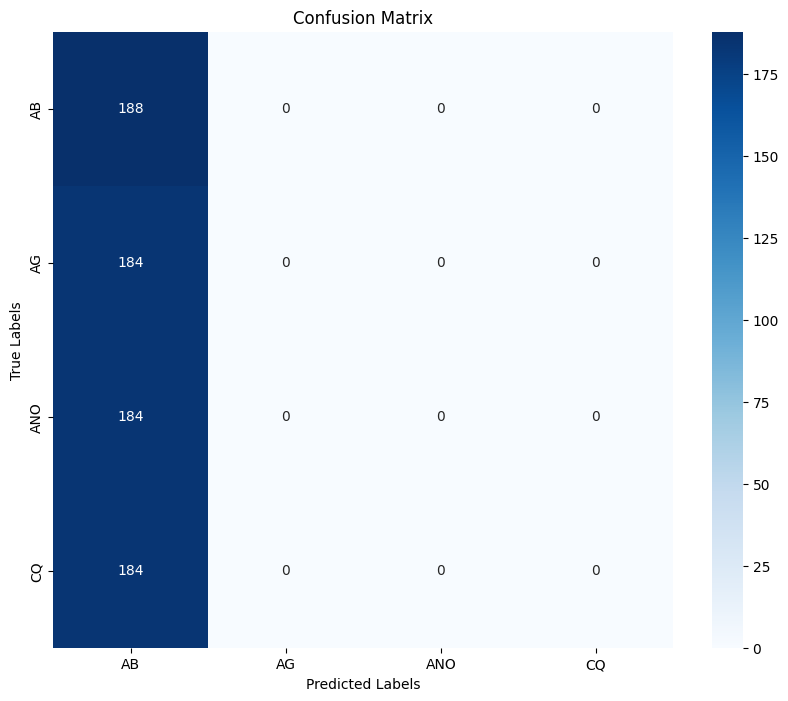

Classification Report:
              precision    recall  f1-score   support

          AB       0.25      1.00      0.41       188
          AG       0.00      0.00      0.00       184
         ANO       0.00      0.00      0.00       184
          CQ       0.00      0.00      0.00       184

    accuracy                           0.25       740
   macro avg       0.06      0.25      0.10       740
weighted avg       0.06      0.25      0.10       740



/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/esidserver/miniforge3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

: 

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set paths to your dataset folders
train_dir = '/home/esidserver/datasets/testing_cls/train/'
val_dir = '/home/esidserver/datasets/testing_cls/val/'
test_dir = '/home/esidserver/datasets/testing_cls/test/'

# Image data generator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)

# Load the ResNet-50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Save the final model
model.save('resnet50_final_model.keras')

# Generate predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=cm_labels))